In [1]:
from __future__ import print_function
import torch

In [3]:
a = torch.randn(3, 4, requires_grad=True)
a = torch.randn(3, 4).requires_grad_()
a = torch.randn(3, 4)
a.requires_grad = True
a

tensor([[ 0.5624,  0.4630, -1.0086, -0.1177],
        [ 1.0394,  0.3588, -0.0156, -1.4090],
        [ 0.8525,  0.5206, -0.2713,  0.0252]], requires_grad=True)

In [4]:
b = torch.zeros(3, 4).requires_grad_()
b

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], requires_grad=True)

In [5]:
c = a + b
c

tensor([[ 0.5624,  0.4630, -1.0086, -0.1177],
        [ 1.0394,  0.3588, -0.0156, -1.4090],
        [ 0.8525,  0.5206, -0.2713,  0.0252]], grad_fn=<AddBackward0>)

In [6]:
d = c.sum()
d.backward()

In [7]:
d
d.requires_grad

True

In [8]:
a.grad

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [9]:
a.requires_grad, b.requires_grad, c.requires_grad

(True, True, True)

In [11]:
c.grad is None

D:\Program Files\anaconda\envs\pytorch\lib\site-packages\torch\_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:482.)
  return self._grad


True

In [12]:
def f(x):
    y = x ** 2 * torch.exp(x)
    return y


def grad(x):
    dx = 2 * x * torch.exp(x) + x ** 2 * torch.exp(x)
    return dx

In [13]:
x = torch.randn(3, 4, requires_grad=True)
y = f(x)
y

tensor([[1.7300e-03, 5.2379e-02, 2.1318e-03, 4.5635e-01],
        [4.4034e-01, 2.0507e-02, 5.2812e-01, 1.1320e-01],
        [6.3254e-02, 3.0612e-03, 2.0192e+01, 1.9686e-01]],
       grad_fn=<MulBackward0>)

In [14]:
y.backward(torch.ones(y.size()))
x.grad

tensor([[-0.0797, -0.3494, -0.0881, -0.2549],
        [-0.2796, -0.2446, -0.0925,  0.8914],
        [-0.3717, -0.1045, 42.4535, -0.4610]])

In [15]:
grad(x)

tensor([[-0.0797, -0.3494, -0.0881, -0.2549],
        [-0.2796, -0.2446, -0.0925,  0.8914],
        [-0.3717, -0.1045, 42.4535, -0.4610]], grad_fn=<AddBackward0>)

In [16]:
x = torch.ones(1)
b = torch.rand(1, requires_grad=True)
w = torch.rand(1, requires_grad=True)
y = x * w
z = y + b

In [18]:
x.requires_grad, b.requires_grad, z.requires_grad

(False, True, True)

In [19]:
y.requires_grad

True

In [20]:
x.is_leaf, w.is_leaf, b.is_leaf

(True, True, True)

In [21]:
y.is_leaf, z.is_leaf

(False, False)

In [22]:
z.grad_fn

In [23]:
z.grad_fn.next_functions

((<MulBackward0 at 0x192cbe2bb80>, 0), (<AccumulateGrad at 0x192cbe40a60>, 0))

In [25]:
z.grad_fn.next_functions[0][0] == y.grad_fn

True

In [26]:
y.grad_fn.next_functions

((None, 0), (<AccumulateGrad at 0x192cbe29880>, 0))

In [27]:
w.grad_fn, x.grad_fn

(None, None)

In [28]:
z.backward(retain_graph=True)
w.grad

tensor([1.])

In [29]:
z.backward()
w.grad

tensor([2.])

In [30]:
from torch.autograd import Function


class MultiplyAdd(Function):
    @staticmethod
    def forward(ctx, w, x, b):
        ctx.save_for_backward(w, x)
        output = w * x + b
        return output

    @staticmethod
    def backward(ctx, grad_output):
        w, x = ctx.saved_tensors
        grad_w = grad_output * x
        grad_x = grad_output * w
        grad_b = grad_output * 1
        return grad_w, grad_x, grad_b

In [31]:
x = torch.ones(1)
w = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)

z = MultiplyAdd.apply(w, x, b)
z.backward()

x.grad, w.grad, b.grad

(None, tensor([1.]), tensor([1.]))

In [32]:
class Sigmoid(Function):
    @staticmethod
    def forward(ctx, x):
        output = 1 / (1 + torch.exp(-x))
        ctx.save_for_backward(output)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        output, = ctx.saved_tensors
        grad_x = output * (1 - output) * grad_output
        return grad_x

In [34]:
# 采用数值逼近方式检验计算梯度的公式对不对
test_input = torch.randn(3, 4, requires_grad=True).double()
torch.autograd.gradcheck(Sigmoid.apply, (test_input,), eps=1e-3)

True

In [36]:
def f_sigmoid(x):
    y = Sigmoid.apply(x)
    y.backward(torch.ones(x.size()))


def f_naive(x):
    y = 1 / (1 + torch.exp(-x))
    y.backward(torch.ones(x.size()))


def f_th(x):
    y = torch.sigmoid(x)
    y.backward(torch.ones(x.size()))


x = torch.randn(100, 100, requires_grad=True)
% timeit -n 100 f_sigmoid(x)
% timeit -n 100 f_naive(x)
% timeit -n 100 f_th(x)

142 µs ± 7.73 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
151 µs ± 4.29 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
146 µs ± 7.35 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
from matplotlib import pyplot as plt
from IPython import display

import numpy as np
import torch

% matplotlib inline

In [38]:
torch.manual_seed(1000)


def get_fake_data(batch_size=8):
    x = torch.rand(batch_size, 1) * 5
    y = x * 2 + 3 + torch.randn(batch_size, 1)
    return x, y

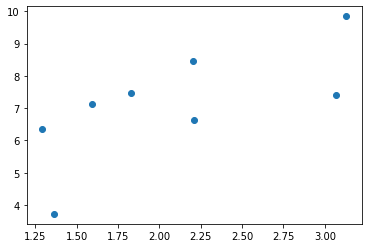

In [39]:
x, y = get_fake_data()
plt.scatter(x.squeeze().numpy(), y.squeeze().numpy())

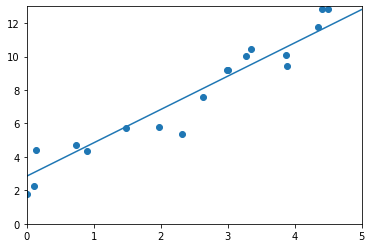

2.0448379516601562 2.9823975563049316


In [43]:
w = torch.rand(1, 1, requires_grad=True)
b = torch.zeros(1, 1, requires_grad=True)
losses = np.zeros(500)

lr = 5e-3

for i in range(500):
    x, y = get_fake_data(batch_size=32)
    y_pred = x.mm(w) + b.expand_as(y)
    loss = 0.5 * (y_pred - y) ** 2
    loss = loss.sum()
    losses[i] = loss.item()

    loss.backward()

    w.data.sub_(lr * w.grad.data)
    b.data.sub_(lr * b.grad.data)

    w.grad.data.zero_()
    b.grad.data.zero_()

    if i % 50 == 0:
        display.clear_output(wait=True)
        x = torch.arange(0, 6).view(-1, 1).float()
        y = x.mm(w.data) + b.data.expand_as(x)
        plt.plot(x.numpy(), y.numpy())

        x1, y1 = get_fake_data(batch_size=20)
        plt.scatter(x1.numpy(), y1.numpy())

        plt.xlim(0, 5)
        plt.ylim(0, 13)
        plt.show()
        plt.pause(0.5)

print(w.item(), b.item())

(5.0, 50.0)

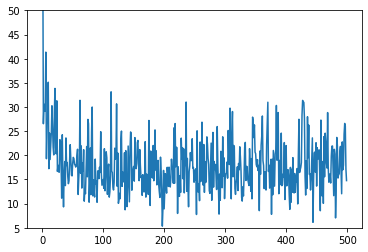

In [44]:
plt.plot(losses)
plt.ylim(5, 50)